In [1946]:
#each loop produces delta functions for the signs of omegas
#remember we must also rack external omegas generated by the resolution of momenta
#colour the edges for quasimasses, i think that is enough to solve all omega-integrals - simpy plug in values on the basis of colours

# Integrals by sub

In [1947]:
from sympy import *
import operator
import functools
init_printing()
#init_printing(use_latex='mathjax')

In [1948]:
#todo see how to use DiracDelta etc. in sympy for now i just want to be explicit
#https://docs.sympy.org/latest/modules/functions/special.html

class delta_constraint(object):
    def __init__(self, names):
        self._exp = functools.reduce(operator.add, [Symbol(n) for n in names] , 0)
        self._rep = Function("delta")(self._exp)
        
    def __repr__(self):  return self._repr_latex_()
    def _repr_latex_(self): return latex(self._rep,  mode='inline')
    def __call__(self, i):
        return solve(self._exp, Symbol("alpha"+"_"+(str(i))))[0]
    
class ddelta(object):
    def __init__(self, name, vec):
        self._name = name
        self._d = Symbol("delta")
        self._vec = symbols(" ".join([name+"_"+str(abs(v)) for v in range(len(vec))]))
        signed = lambda v : [vec[i] * self._vec[i] for i in range(len(vec))]
        self._signed = signed(self._vec)
        self._exp = functools.reduce(operator.add, self._signed, 0)
        self._rep = Function("delta")(self._exp)
    def __repr__(self):  return self._repr_latex_()
    def _repr_latex_(self): return latex(self._rep,  mode='inline')
    def __call__(self, i):
        return solve(self._exp, Symbol(self._name+"_"+(str(i))))[0]
    
    @property
    def value(self):return self._rep
        
    def substitution(self, i):
        term = self._signed[i]
        return {term :self(i)}
    
    
class explicit_ddelta(object):
    def __init__(self, key, val_list):
        self._exp = functools.reduce(operator.add, [key] + val_list , 0)
        self._rep = Function("delta")(self._exp)
        
    def __repr__(self):  return self._repr_latex_()
    def _repr_latex_(self): return latex(self._rep,  mode='inline')
    def __call__(self, i):
        return solve(self._exp, Symbol("alpha"+"_"+(str(i))))[0]
        
    
class signed_delta(explicit_ddelta):
    def __init__(self,name,index):
        explicit_ddelta.__init__(self,key=Symbol(name+"_"+str(index)+"^+"), val_list=[Symbol(name+"_"+str(index)+"^-")])
    
ddelta("alpha", [1,-1,-1]).substitution(0)
#explicit_ddelta(key=Symbol("omega_0^+"), val_list=[Symbol("omega_0^-")])
#signed_delta("omega",0)._rep

In [1949]:
delta_constraint(["a_1", "a_2", "f_9"])

$\delta{\left (a_{1} + a_{2} + f_{9} \right )}$

In [1950]:
import numpy as np
class __coeff__(object):
    def __init__(self, omegas=[-1*I], Dks=[[1]], ms=[1]):
        self._o = np.array(omegas)
        self._dk = np.array(Dks)
        self._m = ms

def sum_terms(name, coeff,use_letters=False):
    labels = [str(i) for i in range(len(coeff))] if not use_letters else ["a","b","c","d","e"]
    
    return [v* Symbol(name+"_"+labels[i]) for i, v in enumerate(coeff) ]

sum_terms("omega^+", [-1,1,-1])

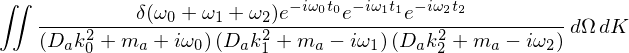

In [1951]:
def _sum_(terms): return functools.reduce(operator.add, terms , 0)

#def _double_sum_ops(names, tensor): _sum(names[0], _sum_(names[1], [for t in tensor])

class _scalar_propagator_(object):
    #coeff = for known species vector space, loop im
    def __init__(self,  index=0, coeff=__coeff__(), sense=-1, power=1):
        self._index = index
        self._power = power
        self._coeff = coeff
        self._sense = sense #topology
         
        _ks = [(_sum_(sum_terms("k", t)))**2 for t in self._coeff._dk]
        
        sense_term = "omega^+" if sense == 1 else "omega^-"
        sense_term = "omega"
        
        self._den = (_sum_(sum_terms(sense_term,self._coeff._o))
                       +_sum_(sum_terms("m",self._coeff._m,use_letters=True))
                       +_sum_(sum_terms("D",_ks,use_letters=True))
                       )
        self._value = self._den**(-1) 
        
        self._associated_delta_functions = [signed_delta("omega",index)._rep,signed_delta("k",index)._rep]

    @property
    def value(self):
        
        ret = self._value * functools.reduce(operator.mul, self._associated_delta_functions , 1)
        
        return ret.simplify()
        
    def __repr__(self):  return self._repr_latex_()
    def _repr_latex_(self): return latex(self.value,  mode='inline')
    def __call__(self, i):pass
    
    def subs(self, d):
        #as below for deltas, we need to keep track of terms seperately to avoid rediscovery, which needs cleaning up
        self._den = self._den.subs(d)
        self._value = self._value.subs(d)
        return self
    
    def apply_delta(self, d,i):
        #hacky - I have not thought out how these workflows should be done yet but I will
        self._den = self._den.subs(d.substitution(i))
        self._value = self._value.subs(d.substitution(i))
        
        return self
    
    def apply_delta_functions(self):
        #hack
        self._associated_delta_functions = []
        if self._sense == 1: 
            self._value=self._value.subs({"omega_"+str(self._index): -1*Symbol("omega_"+str(self._index)) })
            #hack see above
            self._den = self._den.subs({"omega_"+str(self._index): -1*Symbol("omega_"+str(self._index)) })
            
        return self
    
    def Ltransform(self):
        self._value = self._value #* exp(-I*Symbol("omega_"+str(self._index))*Symbol("t_"+str(self._index)))
        return self
    
    def Ftransform(self):
        self._value = self._value * exp(-I*Symbol("omega_"+str(self._index))*Symbol("t_"+str(self._index)))
        return self
    
def __prod__(l): return functools.reduce(operator.mul, l,1)
    
from IPython.display import Latex

class _integral_(object):
    def __init__(self, propagators, delta_funcs = [], dims=0):
        #d,k,o,p = symbols ("d k omega pi")
        #self.m = __prod__([ d*o/(2*p) for i in range(dims)]) * __prod__([ d*k**d/(2*Symbol("pi")**d) for i in range(dims)])
        self._propagators = [p for p in propagators]
        self._delta_funcs = [d for d in delta_funcs]
        
    def __repr__(self):  return self._repr_latex_()
    def _repr_latex_(self): 
        #init_printing(use_latex='mathjax')
        return latex(__prod__(self._propagators))
    #is it algorithmically quivalent to treat a multiple pole as two seperate poles?
    # no because that produces singular
    def find_zeros(self, sym, as_delta_functions=False):
        pass
    
    def subs(self,d):
        for d in self._delta_funcs: self._propagators = [p.subs(d) for p in self._propagators]
        return self
    
    def apply_deltas(self, i):
        for d in self._delta_funcs:
            self._propagators = [p.apply_delta(d,i) for p in self._propagators]
        self._delta_funcs = []
        return self
    
    @property
    def integral(self):
        l = [p.value for p in self._propagators] + [d.value for d in self._delta_funcs]
        return Integral( __prod__(l) ,(Symbol("\Omega")),(Symbol("K")))


C1 = __coeff__(Dks=[[1,0,0]], omegas=[I,0,0])
C2 = __coeff__(Dks=[[0,1,0]], omegas=[0,I,0])
C3 = __coeff__(Dks=[[0,0,1]], omegas=[0,0,I])

P1 = _scalar_propagator_(index=0,coeff=C1,sense=-1).apply_delta_functions().Ftransform()
P2 = _scalar_propagator_(index=1,coeff=C2,sense=1).apply_delta_functions().Ftransform()
P3 = _scalar_propagator_(index=2,coeff=C3,sense=1).apply_delta_functions().Ftransform()

IG = _integral_([P1,P2,P3],[ddelta("omega", [1,1,1])]).integral
IG
#remember there are twice as many integrals for senses propagators and the delta functions and integrals cancel only half of them!!

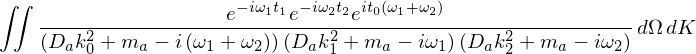

In [1952]:

IG = _integral_([P1,P2,P3],[ddelta("omega", [1,1,1])]).apply_deltas(0)
IG.integral

In [1953]:
def omega_solutions(IG, ofilter=None, isolate=False, evaluate=true):
    ofilter = "omega" if ofilter == None else ofilter
    #todo deal with multiple poles
    for expression in [P._den.expand() for P in IG._propagators]:
        for omega in [o for o in expression.as_ordered_terms() if ofilter in str(o)]:      
            #if omega is negative, maybe write in terms of positive but test workflow first
            factor = list(ter.as_coefficients_dict().values())[0] * I
            for sol in solve(expression, omega):
                res = {omega : sol.simplify()} if not isolate else { omega/factor : (sol/factor).simplify()}
                
                #if eval, identify f_hat as IG_prod / P._den
                
                #in reality we need to apply the contractions for each "loop" before continuing 
                #this is to say we iterate the integrals
                
                yield res
                
            
subit = list(omega_solutions(IG, "omega_1",isolate=True))[0]
subit
#P3.subs(subit)

In [1954]:
#figure out how to subclass express
G = -I * Symbol("omega_0")
str(G)

'-I*omega_0'

In [1955]:
class mom(Mul):
    def __new__(self, index=0):
        return Mul.__new__(self,  Symbol("k_"+(str(index)))**2)
               
class causal(Mul):
    def __new__(self, index=0,sign=-1):
        return Mul.__new__(self, sign* I * Symbol("omega_"+(str(index))))
        
class propagator(Mul):
    def __new__(self, i,sign=-1, a="a"):
        return Mul.__new__(self, 1/(causal(i,sign) +Symbol("D_"+a)* mom(i) + Symbol("m_"+a) ))

def __prod__(l): return functools.reduce(operator.mul, l,1)

def ftransform(var, to="t"):
    subscript = str(var).split("_")[-1]
    return exp(-I*var*Symbol(to+"_"+subscript))

class ddelta(object):
    def __init__(self, name, vec):
        self._name = name
        self._d = Symbol("delta")
        self._vec = symbols(" ".join([name+"_"+str(abs(v)) for v in range(len(vec))]))
        signed = lambda v : [vec[i] * self._vec[i] for i in range(len(vec))]
        self._signed = signed(self._vec)
        self._exp = functools.reduce(operator.add, self._signed, 0)
        self._rep = Function("delta")(self._exp)
    def __repr__(self):  return self._repr_latex_()
    def _repr_latex_(self): return latex(self._rep,  mode='inline')
    def __call__(self, i):
        return solve(self._exp, Symbol(self._name+"_"+(str(i))))[0]
    
    @property
    def value(self):return self._rep
        
    def substitution(self, i):
        term = self._signed[i]
        return {term :self(i)}

In [1956]:
ftransform(causal(0))

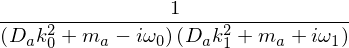

In [1957]:
propagator(0,-1)*propagator(1,1)

In [1958]:
#check my theory of integration
#i aut-fix contours for any one integration variable so as not to integrate both signs - but be careful that we have correct signs
#The iterated integrals dont interfer with resect to integration causal variables
#need to apply delta functions and transforms - the later is tricky because i need to track actual propagators
class propagator_inspector(object):
    def __init__(self, val):
        #temp I have some code that does this properly
        self._props = [1/p for p in val.as_numer_denom()[-1].as_ordered_factors()]
        self._d = {}
        self._var_set = []
        
        for prop in self._props:
            t = prop.as_powers_dict()
            base = list(t.keys())[0] 
            #for all omega variables in the propagator
            for omega in [t for t in base.expand().as_ordered_terms() if "omega" in str(t)]:
                eval_omega = omega.args[-1]
                self._var_set.append( eval_omega)
                sol = solve(base,eval_omega)[0]
                if eval_omega not in self._d: self._d[eval_omega] = {}
                #print("storing pole",str(eval_omega),"=",str(sol))
                #pole omega=sol
                self._d[eval_omega][sol] = {"base":base,  "value": prop,  "order": abs(list(t.values())[0]),  
                     "causal_variable":  eval_omega,
                                     #I think there is a better way to get this complex coefficient - must dig
                    "causal_sign" : omega.args[0] if len(omega.args)==3 else 1,
                    "quasimass" : sol #note i take the first solution of which i can prove there is one?
                            }

        self._var_set = set(self._var_set)
        
    def __getitem__(self,k): return self._d[k]
        
    def __iter__(self):  
        for p in self._props: yield p
    #make me a dictionary and return properties of any supplied propagator - allow power invariance??  
    
    #properties like pole order, zeroes, omega term, causal coefficient
    
class graph_integrand(object):
    def __init__(self, propagator_list, delta_functions = [], transforms=[]):       
        self._props = propagator_list if isinstance(propagator_list,list) else propagator_inspector(propagator_list)
        self._delta_functions = delta_functions      
        self._transforms = transforms      
        
        pi = propagator_inspector(self.value)
        self._omega_vars =  list(pi._var_set)
        
    @property
    def value(self):  
        deltas = __prod__([d.value for d in self._delta_functions])
        return __prod__(self._props) *deltas
    
    def integration_variables(self): return self._omega_vars

    def apply_delta_functions(self,i):
        _g = self
        for d in self._delta_functions:
            _g =  graph_integrand(self.value.subs(d.substitution(i)).simplify())
        return _g
    
    def __mul__(self,p): 
        newval = __prod__(self._props) * p
        #self._props = list(propagator_inspector(newval)) 
        return graph_integrand(list(propagator_inspector(newval)))
    
    def __truediv__(self,p): 
        newval = __prod__(self._props) / p
        #self._props = list(propagator_inspector(newval))
        return graph_integrand(list(propagator_inspector(newval)))
    
    def __call__(self, val, omega=None):
        omega = omega if omega != None else self._omega_vars[0]
        return self.value.subs({omega:val})
    
    def __repr__(self):  return self._repr_latex_()
    def _repr_latex_(self):  return latex(self.value,mode='inline')
     
    def factor(pole_structure):
    #usethe sign of the var and also the order of the pole
        return 1
    
    def poles_for(self, int_var=None):
        return list(graph_integrand.poles(self, int_var))
        
    def poles(intg,int_var=None):
        #for now I show the propagtors as the value
        pi = propagator_inspector(intg.value)

        def _gen_poles_(v): #poles where v=k
            fixed_contour = None
            poles_for_var = pi[v]
            for k,_p in poles_for_var.items():
                if fixed_contour == None: fixed_contour = _p["causal_sign"]
                #auto fix contout of integration for poles of this integration variable - dont mixed siges
                if _p["causal_variable"] == v and _p["causal_sign"] == fixed_contour: 
                    yield _p
                    
        keys = [int_var] if int_var != None else list(pi._d.keys())
        for k in keys:
            for p in _gen_poles_(k):
                yield p

    def D(self,order):
        return self#for now

    def residues(intg,v):
        for p in graph_integrand.poles(intg,v):
            #(n-1)th derivitive of f/P evaluated for the pole    
            g = (intg/p["value"]).D(p["order"]-1)
            val = factor(p) * g(p["quasimass"],v)
            #propagators simpification - may not work with transforms
            yield __prod__([p.simplify() for p in val.as_ordered_factors()])
            
    def integrate(intg,integration_vars=None):
        f = graph_integrand(intg.value)
        integration_vars = f._omega_vars if integration_vars == None else integration_vars
        for v in integration_vars:
            print("integrating", v)
            res = [r for r in graph_integrand.residues(f,v)]
            f = _sum_(res)
            f = graph_integrand(f)
        return f
    
    def _integrate_(self):return graph_integrand.integrate(self)
                

In [1959]:
IG = graph_integrand(prod([propagator(0,1),propagator(1,-1),propagator(2,-1)]), delta_functions=[ddelta("omega", [1,1,1])])
#IG = graph_integrand(prod([propagator(0,-1),propagator(0,1)]))
IG

$\frac{\delta{\left (\omega_{0} + \omega_{1} + \omega_{2} \right )}}{\left(D_{a} k_{0}^{2} + m_{a} + i \omega_{0}\right) \left(D_{a} k_{1}^{2} + m_{a} - i \omega_{1}\right) \left(D_{a} k_{2}^{2} + m_{a} - i \omega_{2}\right)}$

In [1960]:
#pi = propagator_inspector(IG.value)
#for k,v in pi[Symbol("omega_0")].items(): print(k,v)

In [1961]:
IGG = IG.apply_delta_functions(0)
IGG
#IGG.poles_for()

$\frac{1}{\left(D_{a} k_{0}^{2} + m_{a} - i \left(\omega_{1} + \omega_{2}\right)\right) \left(D_{a} k_{1}^{2} + m_{a} - i \omega_{1}\right) \left(D_{a} k_{2}^{2} + m_{a} - i \omega_{2}\right)}$

In [1963]:
#vb = IGG.integrate([Symbol("omega_1")]).value#.simplify()

In [1965]:
#vb = IGG.integrate().value#.simplify()

In [1966]:
vb.as_numer_denom()[-1].expand()

In [ ]:
# propagator manager should simplify these things as effectively simply terms with collected -iomega terms

## Now do loop integrals

In [ ]:
#To do this properly I need to implement the vertex delta functions with external momenta

In [1967]:
IG = graph_integrand(prod([propagator(0,1),propagator(0,-1),propagator(0,-1)]))
IG

$\frac{1}{\left(D_{a} k_{0}^{2} + m_{a} - i \omega_{0}\right)^{2} \left(D_{a} k_{0}^{2} + m_{a} + i \omega_{0}\right)}$

In [ ]:
IG.integrate()

# Enumerating and drawing diagram symmetries

In [2439]:
import numpy as np
class incidence_matrix(np.ndarray):  
    #todo allow a dictionary of letters maybe for vertices to make it easier to init and maybe consider not using sizes
    def __new__(self, edge_count, vertex_count, edges=[],external_vertices=[]):
        size = (vertex_count+ (1 if len(external_vertices) > 0 else  0),edge_count+len(external_vertices))
        obj = super(incidence_matrix, self).__new__(self, size, np.int)  
        obj[:] = 0 
        obj.add_edges(edges + [[-1,ev] for ev in external_vertices])
        obj._external_vertices = external_vertices
        obj._internal_vertices = list(set(list(range(vertex_count))) - set(external_vertices))
        self._edges =edges
        return obj
            
    def flip_edges(self,edge_indecies):
        if not isinstance(edge_indecies,list): edge_indecies =[edge_indecies]
        for e in edge_indecies:self[:,e]*= -1
        return self
        
        
    def reset_edge_orders(self, edges):pass
    def reset_edge_orders_from_hierarchy(self):pass
    
    def exists_directed_edge(self,a,b):
        """
        checks all the columns (edges) to see if there is an edge that starts at a(-1) and endgs at b(1)
        """
        for i,r in enumerate(INC.T):
            if(r[a]==-1) and (r[b]==1):
                return True
        return False
    
    @property
    def edges(self): return self._edges
        
    @property
    def internal_vertices (self):return self._internal_vertices
    
    @property
    def external_vertices (self):return self._external_vertices
    
    def get_coincident_vertices_any(self, vset,exclusions = []):
        items = []
        for v in vset:
            for _v in self.get_coincident_vertices(v,exclusions):
                if _v not in items: items.append(_v)
        return items
        
    def get_coincident_vertices(self, v,exclusions = []):
        #these are the data columns for which v has edge data
        v_inc_frame = self[:,np.where(self[v]!=0)[0]]
        exclusions = exclusions+ [v]
        #now get the row index for things that are co-incident using the trick but just checking non zero rows
        #this is a bit odd and probably better way but count non zero columns uses the count and nonzero combined 
        #and we ensure that v is not in the list which is requred when it has only one edge for example
        incident_vertices = [l for l in list(np.nonzero((np.count_nonzero(v_inc_frame,axis=1)==1).astype(int))[0]) if l not in exclusions]
        return incident_vertices
        
    def add_edges(self, eset):
        for i, v in enumerate(eset): 
            self[v[0],i],self[v[1],i] = 1,-1
            
    def vertex_hierarchy(self, vset=[-1], d=0, h={} ):
        """
        recursion from external nodes or other seed set
        """
        if d ==0: h= {}
        #need to re-think the indexing a little
        #this is so that I can store the last vertex (inf) as either -1 or the length of the thing
        if -1 in vset:h[len(self)-1] = 2
        for _v in vset: h[_v] = d
        if len(vset) > 0:yield d, vset
        #look for any coincident vertices that are not on my level or above
        next_layer = self.get_coincident_vertices_any(vset ,vset+ list(h.keys()))
        if(len(next_layer)>0):
            for t in self.vertex_hierarchy(next_layer,d+1,h):
                yield t
    
    
    @property
    def flat_adjacency(self): return [ list(np.nonzero(v)[0]) for v in  self.adjacency_with_inf]
      
    @property
    def adjacency(self):
        #[ np.nonzero(v)[0]for v in  INC.adjacency_with_inf]
        return self.adjacency_with_inf[:-1,:-1]
    
    @property
    def adjacency_with_inf(self):
        ad = np.zeros((len(self),len(self)),np.int)
        for i, v in enumerate(self):  ad[i][self.get_coincident_vertices(i)]  =1
        return ad[:-1,:-1] if len(self._external_vertices) > 0 else ad
    

    @property
    def edge_labels(self):
        #the last row is the external vertex so check which edges are connected
        ex_edges = np.nonzero(self[-1])[0]
        return [ "p"+str(i) for i in range(self.shape[-1]) if i not in ex_edges]   +   [ "q"+str(i) for i in range(len(ex_edges))]
       
    @property
    def vertex_constraints(self):
        edge_labels = self.edge_labels
        for v in self:
            yield delta_constraint([edge_labels[i] for i in np.nonzero(v)[0]])
            
INC = incidence_matrix(9, 6,
                       [ [0,1], [1,2], [2,0], [3,4],[4,3],[3,0],[4,2], [4,5], [5,3] ],
                       external_vertices=[0,1,2])

INC.edge_labels

['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'q0', 'q1', 'q2']

In [2441]:
INC.exists_directed_edge(1,0)

True

In [2442]:
INC.flip_edges(0)

incidence_matrix([[-1,  0, -1,  0,  0, -1,  0,  0,  0, -1,  0,  0],
                  [ 1,  1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0],
                  [ 0, -1,  1,  0,  0,  0, -1,  0,  0,  0,  0, -1],
                  [ 0,  0,  0,  1, -1,  1,  0,  0, -1,  0,  0,  0],
                  [ 0,  0,  0, -1,  1,  0,  1,  1,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1]])

In [2443]:
INC.exists_directed_edge(1,0)

False

In [2419]:
a,b = 1,0
for i,r in enumerate(INC.T):
    if(r[a]==-1) and (r[b]==1):
        print(i)

0


In [1970]:
INC.flat_adjacency

[[1, 2, 3], [0, 2], [0, 1, 4], [0, 5], [2, 5], [3, 4]]

In [1971]:
graph = INC.edges
graph

In [1972]:
class cycle_finder(object):
    """
    Adapted from
    https://stackoverflow.com/questions/12367801/finding-all-cycles-in-undirected-graphs
    
    #graph = [[1, 2], [1, 3], [1, 4], [2, 3], [3, 4], [2, 6], [4, 6], [8, 7], [8, 9], [9, 7]]
    graph = [[0,1], [0,2], [1,2], [1,3], [2,3]]

    for p in cycle_finder(graph): print(p) #returns the edges in the circuit indexed from the graph
    for p in cycle_finder(graph, "vertices"): # returns the vertices in the cicuit

    """
    def __init__(self, graph_edges, c_type="edges"):
        self.graph = graph_edges
        self.cycles = []  
        self.c_type = c_type
        for edge in graph:
            for node in edge:  
                self.findNewCycles([node])
    
    def __expand_edges__(self, vlist):
        for i,v in enumerate(vlist): 
            yield sorted([vlist[i-1],v])
            
    @property
    def cycle_Basis(self):
        l = list(self)
        b = np.zeros((len(l),len(self.graph)),np.int)
        for i,r in enumerate(b): r[l[i]] = 1
        return b
    
    def __iter__(self):
        for cy in self.cycles:
            res = [node for node in cy]
            if self.c_type == "vertices": yield res
            else: yield [self.graph.index(e) for e in self.__expand_edges__(res)]
               
    def findNewCycles(self,path):
        def isNew(path): return not path in self.cycles
        def visited(node, path):  return node in path
        def invert(path):return rotate_to_smallest(path[::-1])
        def rotate_to_smallest(path):
            n = path.index(min(path))
            return path[n:]+path[:n]   
        
        start_node,next_node,sub = path[0],None,[]
        
        for edge in self.graph:
            node1, node2 = edge
            if start_node in edge:
                    next_node = node2 if node1 == start_node else node1
            if not visited(next_node, path):
                    sub = [next_node]
                    sub.extend(path)
                    self.findNewCycles(sub);
            elif len(path) > 2  and next_node == path[-1]:
                    p = rotate_to_smallest(path);
                    inv = invert(p)
                    if isNew(p) and isNew(inv):  
                        self.cycles.append(p)
                        
                        
graph = [[0,1], [0,2], [1,2], [1,3], [2,3]]
for p in cycle_finder(graph): print(p)
f = cycle_finder(graph)
f.cycle_Basis

[0, 1, 2]
[0, 1, 4, 3]
[2, 3, 4]


array([[1, 1, 1, 0, 0],
       [1, 1, 0, 1, 1],
       [0, 0, 1, 1, 1]])

In [1973]:
# turn this into completed edges in canonical form
# then compare with the edges we put in in canonical form

In [1974]:
    
D = ring_diagram(INC) 
D

In [2409]:
#Tasks: (1) add direction markers from the incidence matrix (2) use indep cycles to choose a cycle orientation - walk any and leave last man standing

class arc(object):
    def __init__(self, angles, radius,center=None,size=None,change_sense=False):
        self.radius = radius
        object_radius = 20 + radius
        self.center = (object_radius,object_radius) if center is None else center
        self.size=(2*object_radius,2*object_radius) if size is None else size
        self.body = ""
        self.header =  arc.get_header()
        self.change_sense = change_sense
        
        startAngle,endAngle = angles[0],angles[1]    
        mid_angle = (startAngle+endAngle)/2.
        
        #self.body+= """<circle cx="{0}" cy="{1}" r="2" stroke="black" stroke-width="1" fill="red" /> """.format(*self.center)
            
        self.body+= self.__describeArc__(startAngle, endAngle)
        self.body+= self.__describeArc__(startAngle, mid_angle, decorations="marker-end='url(#markerArrow)'")
           
    def get_header():
        return """<defs><marker id="markerArrow" markerWidth="13" markerHeight="13" refX="2" refY="6" orient="auto">
                    <path d="M2,2 L2,11 L10,6 L2,2" style="fill: #000000;" />
                </marker></defs>"""
    
    def __polarToCartesian__(self, angleInDegrees, radius, center):
        centerX, centerY = center[0], center[1]
        angleInRadians = (angleInDegrees-90) *math.pi / 180.0;
        return int( centerX + (radius * math.cos(angleInRadians))), int( centerY + (radius * math.sin(angleInRadians))), angleInDegrees
          
    def __describeArc__(self, startAngle, endAngle, decorations=""):
        radius = self.radius
        wrap,sweepFlag = (0,0) if endAngle < startAngle  else (0,1)

        start = self.__polarToCartesian__(startAngle+wrap, radius, self.center) 
        end = self.__polarToCartesian__(endAngle+wrap, radius, self.center)
        colour = "black"
        largeArcFlag = "0" if endAngle - startAngle <= 180 else "1"
        #print(startAngle+wrap,endAngle+wrap, largeArcFlag, sweepFlag)
        d = [  "M", start[0], start[1], "A", radius, radius, 0, largeArcFlag, sweepFlag, end[0], end[1]  ]
        d = " ".join([str(_d)+" " for _d  in d] )   
        
        transfrm =  ""#  """transform="rotate(180, {}, {}) scale(1, -1) translate(0, -150)" """.format(*self.center) if self.change_sense else ""
        
        return """<path d="{}" stroke="{}"  stroke-width:1px" {} {}/>""".format(d,colour, decorations, transfrm) 
    
    def __repr__(self):return self.header + self.body
    
    def _repr_html_(self): 
        return   """<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.1" x="{1}" y="{2}" width="{3}" height="{4}">
      <g fill="none" stroke="black" stroke-width="1.6" stroke-linecap="round"> {0}  </g> </svg>""".format(self.__repr__(),  *self.center, *self.size)

arc((130,250),radius=50,change_sense=False)

<defs><marker id="markerArrow" markerWidth="13" markerHeight="13" refX="2" refY="6" orient="auto">
                    <path d="M2,2 L2,11 L10,6 L2,2" style="fill: #000000;" />
                </marker></defs><path d="M  108  102  A  50  50  0  0  1  23  87 " stroke="black"  stroke-width:1px"  /><path d="M  108  102  A  50  50  0  0  1  61  119 " stroke="black"  stroke-width:1px" marker-end='url(#markerArrow)' />

In [2410]:
arc((230,130),radius=50,change_sense=False)

<defs><marker id="markerArrow" markerWidth="13" markerHeight="13" refX="2" refY="6" orient="auto">
                    <path d="M2,2 L2,11 L10,6 L2,2" style="fill: #000000;" />
                </marker></defs><path d="M  31  102  A  50  50  0  0  0  108  102 " stroke="black"  stroke-width:1px"  /><path d="M  31  102  A  50  50  0  0  0  70  120 " stroke="black"  stroke-width:1px" marker-end='url(#markerArrow)' />

In [2445]:
import math
import pandas as pd
#someone needs to deal with colours and combinations for cicuits, sign allocations, quasimass colour
#an integral needs to be generated from the incidence matrix using some Feynman rules

 
    
class ring_diagram(object):
    """
    This one uses a concentric circle arrangement starting from nodes connected to v_\{infty}
    """
    def __init__(self, inc_matrix, options={}):
        self.x = 0
        self.y = 0
        self.margin = 10
        self.radius = 90
        center = self.radius+self.margin
        self._size=(200,200)
        self._center = (center,center)
        self.body = ""
        self._options = options
        self._inc = inc_matrix
        self._vertex_depths = [v[1] for v in list(self._inc.vertex_hierarchy())][1:]
        self._metadata = {}
        
    @property
    def external_vertices(self):mpass

    def __circuit_permutations__(self):
        #so for all adjacency matrix entries, permute so as to choose a particular cycle set
        #oursource to algorithm
        yield None
        
    def __circuit_edge_permutations__(self):
        #for each cycle set, choose the independent cylces by fixing an edge delegate in each independent cicuit
        yield None
        
    def __measure_inter_layer_chords__(self, existing_coords, proposed_coords):
        return 0
    
    def __polarToCartesian__(self, angleInDegrees, radius, center):
        centerX, centerY = center[0], center[1]
        angleInRadians = (angleInDegrees-90) *math.pi / 180.0;
        return int( centerX + (radius * math.cos(angleInRadians))), int( centerY + (radius * math.sin(angleInRadians))), angleInDegrees
    
    def __set_vertex_property__(self, i, key, value):
        if i not in self._metadata: self._metadata[i] = {}
        self._metadata[i][key] = value
        
    def __get_vertex_property__(self, i, key,value):
        if i in self._metadata and key in self._metadata[i]:return self._metadata[i][p]
    
    def __arrange__(self, angle, radius, vset, center=None, prev_layer_connections={}):
        center = center if center is not None else self._center
        if angle == 360: 
            self.__set_vertex_property__(vset[0], "point", center)
            return [center]#if the angle is 360 this can only be a dot in the center
        m,accepted = 1,None
        for offset in [angle]:
            proposed = [self.__polarToCartesian__( (i+1)*angle, radius,center) for i, v in enumerate(vset)]
            _m = self.__measure_inter_layer_chords__(prev_layer_connections, proposed)
            if m ==-1 or _m < m: 
                accepted, m = proposed, _m
                for i,v in enumerate(vset):
                    self.__set_vertex_property__(v, "point", [proposed[i][0],proposed[i][1]])
                    self.__set_vertex_property__(v, "angle", proposed[i][-1])
                    self.__set_vertex_property__(v, "radius", radius)
                            
        return accepted

    def __describeArc__(self, startAngle, endAngle, radius,change_sense=False):
        return arc((startAngle,endAngle),radius, self._center,self._size, change_sense=change_sense).body    
           
    def try_get_connecting_edges(self, v):
        #look up the metadata for v and get all edges that are adjacent to it that we know about
        for u in self._inc.get_coincident_vertices(v):
            if u in self._metadata and v in self._metadata:   
                #if the max length is exceeded, try to get a nice arc otherwise....
                #max length is the length of the verticle chord connecting the bottom of one disk to the point on the outer disk
                yield self.get_line([self._metadata[v]["point"][0],
                                     self._metadata[v]["point"][1],
                                     self._metadata[u]["point"][0],
                                     self._metadata[u]["point"][1]])
        
    def get_line(self, pts, colour="black", dash_array=None):
        dash_array = """stroke-dasharray='{}'""".format(dash_array) if dash_array != None else ""
        midpoint = [(pts[0] + pts[2])/2.,(pts[1] + pts[3])/2.]            
        l = """<line x1="{0}" y1="{1}" x2="{2}" y2="{3}" stroke="{4}" stroke-width:2px"  {5}   />""".format(*pts, colour,dash_array )
        hl = """<line x1="{0}" y1="{1}" x2="{2}" y2="{3}" stroke="{4}" stroke-width:2px"  {5}  marker-end='url(#arrow)' />""".format(pts[0], pts[1], midpoint[0], midpoint[1], colour,dash_array )
        return l+hl
    
    def __edge_segments__(self,n,a,b,vset):
        """
        We always arrange vertices on disks seperated by angles. Can only have vertices in [0,360]
        We assume that the id is the arrangment id in order and that a<b for normal sense
        if however b<a, then we have anticlockwise sense and we will change the angles for downstream reflection
        """
        #if there are multiple edges, then allow - otherwise restrict direction - wrapping because its a ring
        if not self._inc.exists_directed_edge(vset[a%len(vset)],vset[b%len(vset)]):a,b, = b,a
        
        cap = lambda x : 0 if x == 360 else x
        slices = 360./n
        first = a*slices
        second = b*slices
        if a< b: return (a*slices,b*slices), False
        return (a*slices,cap(b*slices)), True

    def __display__(self,edge_colouring = None, edge_styles = None):
        ##arrangement algorithm
        #each level of the hiearchy is given a radius >= 0 and maximally seperated items are added
        #there are symmetric locations and these are chosen to minimise arc lengths
        #I think maybe just try rotations of some integer factors of the freedom which is 360/|l| not including the one that gives the symmetry of course      
        marker_style = """<defs><marker id="arrow" markerWidth="1" markerHeight="1" refX="0.1" refY=".1" 
                          orient="auto" markerUnits="strokeWidth"><path d="M0,0 V2 L1,1 Z" fill="#f00" /></marker></defs>"""
        self.body += marker_style
        levels = len(self._vertex_depths)
        
        radii_margins = [20*(levels-(i)) for i in reversed(range(len(self._vertex_depths))) ]
        angles = [(360./len(v)) for v in self._vertex_depths]
        for i, vset in enumerate(self._vertex_depths): 
            radius = self.radius-radii_margins[i]
            for coord in self.__arrange__(angles[i],radius , vset):
                self.body+= """<circle cx="{0}" cy="{1}" r="3" stroke="black" stroke-width="1" fill="black" /> """.format(*coord)
            for j,v in enumerate(vset):#make loops
                if len(vset) == 1: continue
                edge , change_sense = self.__edge_segments__(len(vset),j,j+1,vset)
                self.body += self.__describeArc__(*edge, radius, change_sense=change_sense )

            if i > 0:#after the first layer, connect edges inter-layer
                for v in vset: 
                    for e in self.try_get_connecting_edges(v): self.body += e
         
        return  """<svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" version="1.1" x="{1}" y="{2}" width="{3}" height="{4}">
      <g fill="none" stroke="black" stroke-width="1.6" stroke-linecap="round"> {0}  </g> </svg>""".format(self.body,  self.x, self.y, *self._size)

    #def __repr__(self):return self.__display__()           
    def __div2s__(self,n):
        while n - int(n) == 0:
            n/=2
            if n - int(n) ==0: yield n

                
    def _repr_html_(self): return self.__display__()
    
    @property
    def vertex_delta_functions(self):
        pass
    
    @property
    def loop_delta_functions(self):
        pass
    
D = ring_diagram(INC) 
D

In [2446]:
INC.flip_edges(0)
D = ring_diagram(INC) 
D

In [2428]:
INC

incidence_matrix([[ 1,  0, -1,  0,  0, -1,  0,  0,  0, -1,  0,  0],
                  [-1,  1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0],
                  [ 0, -1,  1,  0,  0,  0, -1,  0,  0,  0,  0, -1],
                  [ 0,  0,  0,  1, -1,  1,  0,  0, -1,  0,  0,  0],
                  [ 0,  0,  0, -1,  1,  0,  1,  1,  0,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0, -1,  1,  0,  0,  0],
                  [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1]])

In [2413]:
D._metadata

{0: {'angle': 120.0, 'point': [160, 135], 'radius': 70},
 1: {'angle': 240.0, 'point': [39, 135], 'radius': 70},
 2: {'angle': 360.0, 'point': [99, 30], 'radius': 70},
 3: {'angle': 180.0, 'point': [100, 150], 'radius': 50},
 4: {'angle': 360.0, 'point': [99, 50], 'radius': 50},
 5: {'point': (100, 100)}}

In [1785]:
#enumerating independent circuits
#if i define an edge cut of size L, all edge contactions at the cuts that preserve the number of loops are valid labellings?
#choose the one that is connected to the most external nodes?
#from this, given an incidence matrix, generate all delta functions including the loop-deltas

#for fun: one algorithm is to (1) pick any unmarked edge, mark as removed and choose an incident vertex,
#(2) take one walk along new edges back making new incident edge, try and find another return path and do the same or pick a new unviisted edge and return to (1)

#https://www.researchgate.net/profile/Roger_Sargent/publication/272481243_Tarjan-1973-_paper_used_in_TfCAPD_course/links/54e513d50cf276cec1731a86/Tarjan-1973-paper-used-in-TfCAPD-course.pdf?origin=publication_list
#https://stackoverflow.com/questions/25898100/enumerating-cycles-in-a-graph-using-tarjans-algorithm

#https://ieeexplore-ieee-org.iclibezp1.cc.ic.ac.uk/stamp/stamp.jsp?tp=&arnumber=1448962

In [1237]:
#treat trees like a Symbol(bin_str) using a a unique binary string for a tree
#we can define the full algebra on the rooted tree class and allow for expressions to be built once each terminal can be resolved
#hopefully we can expand the tree and keep the full AST for pretty printing
#pretty prinint needs to combine latex and SVG elements

# q-Labelling

# Accurate production of initial delta functions

# A generating function for delta functions

In [ ]:
#https://github.com/mathandy/svgpathtools